## Implementing a node property prediction (classification) model <br>
## using some popular GNNs such as GCN, GraphSAGE, Graph Attention Network. <br>
## Tools: PyTorch, Pytorch Geometric
## Datasets: Planetoid datasets (cora/citeseer)



In [1]:
import torch
print(torch.__version__)
#Remember to change runtime type to GPU. 
print(torch.cuda.is_available())

1.9.0+cu111
True


In [2]:
# changed to cu111 since torch on colab has been upgraded
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.9.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 10.4 MB 5.3 MB/s 
     |████████████████████████████████| 3.7 MB 35.9 MB/s 
     |████████████████████████████████| 1.6 MB 38.5 MB/s 
     |████████████████████████████████| 870 kB 34.4 MB/s 
     |████████████████████████████████| 325 kB 6.1 MB/s 
     |████████████████████████████████| 407 kB 34.5 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=2419083a5d86b6e73a300e27729fc0b2fd3f119e24d2c4f59e0b4a5f5a793366
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built torch-geometric


In [3]:
import torch_geometric
torch_geometric.__version__

'2.0.2'

In [4]:
import os
import glob

import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch.optim as optim
import time

import networkx as nx
import numpy as np

from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt


In [5]:
"""
    NO EDITS REQUIRED HERE. 
"""
def train(dataset, args):
    """
      Trains for fixed number of epochs
      Keeps track of training loss and validation accuracy
    """
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNFactory(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    opt = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()),\
                           lr=args.lr, weight_decay=args.weight_decay)
    print(model)
    # train
    losses = []
    val_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          val_acc = test(loader, model)
          val_accs.append(val_acc)
          print("Epoch ", epoch, "Loss: ", total_loss, "Val Acc.: ", val_acc)
        else:
          val_accs.append(val_accs[-1])
    return val_accs, losses

def test(loader, model, is_validation=True):
    """
        Testing module cn be used on validation data/ test data 
        Returns fraction of correct predictions
    """
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

def run(args):
    dataset = Planetoid('/tmp/'+args.dataset, args.dataset)

    val_accs, losses = train_ES(dataset, args)
    # val_accs, losses = train(dataset, args)

    plt.title(dataset.name)
    plt.plot(losses, label="training loss" + " - " + args.model_type)
    plt.plot(val_accs, label="val accuracy" + " - " + args.model_type)
    plt.legend()
    plt.savefig(f"{args.model_type}_{args.dataset}_best.png", dpi=500)
    plt.show()

## Implement the remaining part of GNNFactory


In [6]:
"""
   GNNFactory consists of following functions: 
   1. __init__ : set values for class attributes. Initialize all layers you'll require in the forward function 
   2. set_conv_model : it takes as input args.model_type and returns the corresponding convolution layer
   3. forward: computes forward pass 
   4. loss: computes NLL loss
"""
from torch_geometric.nn import GCNConv, SAGEConv, GATConv

class GNNFactory(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GNNFactory, self).__init__()
        """
           You need to initialize as many convolution layers as specified in args.num_layers
           You can add optional layers like relu and dropout as per you discretion 
           dropout fraction is specified by args.dropout
           
        """
        ######### Your code starts here ###############
        torch.manual_seed(1234567)
        conv = self.set_conv_model(args.model_type)
        assert (args.num_layers > 0)

        self.conv_layers = nn.ModuleList([
            conv(
                input_dim if i==0 else hidden_dim, 
                output_dim if i==(args.num_layers-1) else hidden_dim
            ) 
            for i in range(args.num_layers)
        ])
        
        self.dropout = args.dropout    
        ######### Your code ends here  ################


    def set_conv_model(self, model_type):
        """
             Based on input mode_type return the convolution layer. 
             You can use in-built pytorch geometric modules
             model_type: {'GCN','SAGE','GAT'}
        """
        #### Your code starts here #######  
        if model_type=='GCN':
          return GCNConv
        elif model_type=='SAGE':
          return SAGEConv
        elif model_type=='GAT':
          return GATConv
        ######Your code ends here###############3
        return NULL

    def forward(self, data):
        """
            Implement forards pass here
            comment "return x" and implement your own return statement
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        #####Your code starts here######  
        for layer in self.conv_layers[:-1]:
          x = layer(x, edge_index)
          x = F.relu(x)
          x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv_layers[-1](x, edge_index)
        ######Your code ends here##########
        return F.log_softmax(x, dim=1)  

    def loss(self, pred, label):
        return F.nll_loss(pred, label)


## Implement train_ES using code from train and add early stopping functionality

In [7]:
def train_ES(dataset, args):
    """
      Refer to code in train (copy-paste useful part), incorporate earlystopping 
    """
    patience = 50
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNFactory(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    opt = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()),\
                           lr=args.lr, weight_decay=args.weight_decay)
    print(model)
    # train
    losses = []
    val_accs = []
    best_acc=-1
    best_epoch=0
    best_model=None
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        val_acc = test(loader, model)
        val_accs.append(val_acc)
        print("Epoch ", epoch, "Loss: ", total_loss, "Val Acc.: ", val_acc)

        if val_acc > best_acc:
          best_acc = val_acc
          best_epoch = epoch
          files = glob.glob('*.pkl')
          for file in files:
            os.remove(file)
          torch.save(model.state_dict(), '{}.pkl'.format(epoch))
        else:
          if epoch > best_epoch+patience:
            break

    model.load_state_dict(torch.load('{}.pkl'.format(best_epoch)))
    print("Test Acc: ", test(loader, model, is_validation=False))

    files = glob.glob('*.pkl')
    for file in files:
      os.remove(file)

    return val_accs, losses

## After implementing GNNFactory and train_ES,  run this cell to obtain the plot for training loss and validation accuracy across epochs

GNNFactory(
  (conv_layers): ModuleList(
    (0): GATConv(3703, 256, heads=1)
    (1): GATConv(256, 256, heads=1)
    (2): GATConv(256, 6, heads=1)
  )
)
Epoch  0 Loss:  1.7958077192306519 Val Acc.:  0.58
Epoch  1 Loss:  1.6608333587646484 Val Acc.:  0.658
Epoch  2 Loss:  1.4629415273666382 Val Acc.:  0.684
Epoch  3 Loss:  1.122999906539917 Val Acc.:  0.708
Epoch  4 Loss:  0.7644346952438354 Val Acc.:  0.696
Epoch  5 Loss:  0.4703187346458435 Val Acc.:  0.63
Epoch  6 Loss:  0.28835028409957886 Val Acc.:  0.652
Epoch  7 Loss:  0.2098509520292282 Val Acc.:  0.68
Epoch  8 Loss:  0.20546403527259827 Val Acc.:  0.686
Epoch  9 Loss:  0.1615537703037262 Val Acc.:  0.638
Epoch  10 Loss:  0.15333431959152222 Val Acc.:  0.668
Epoch  11 Loss:  0.1521596908569336 Val Acc.:  0.672
Epoch  12 Loss:  0.17639587819576263 Val Acc.:  0.688
Epoch  13 Loss:  0.150003120303154 Val Acc.:  0.682
Epoch  14 Loss:  0.20235425233840942 Val Acc.:  0.69
Epoch  15 Loss:  0.23444484174251556 Val Acc.:  0.676
Epoch  1

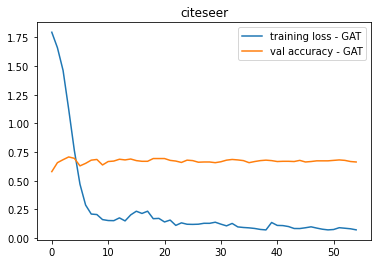

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
from google.colab import files

args = {
        'model_type': 'GAT',
        'dataset': 'citeseer', #"cora/"citeseer"
        'num_layers': 3,
        'batch_size': 32,
        'hidden_dim': 256,
        'dropout': 0.6,
        'epochs': 1000, 
        'opt': 'adam',
        'weight_decay': 2e-2,
        'lr': 0.009
      }
args = objectview(args)

run(args)

files.download(f"{args.model_type}_{args.dataset}_best.png") 

TASKLIST: 
1. Implementation of the GNNFactory function [40 marks]<br>
   Write a brief description of your model.(2-3 sentences) 
2. Implement early stopping  functionality: with patience parameter 50  [10 marks]<br>
   Description: During training, track performance on validation set and
   stop training if validation set performance does not improve for X epochs (X=50)<br>
   You will be keeping track of the best validation model, which will be used for reporting test accuracy<br>
   The current train function trains args.epochs number of epochs. <br>
   Write your own train function (my_train)<br>

3. Reporting best test accuracy across hyperparameters: [30 marks]<br>
   Tune hyperparameters (num_layers,batch_size,hidden_dim,dropout,weight_decay,lr) to obtain best performance<br>
   for ["GCN","SAGE","GAT"] and ["cora","citeseer"]:<br>
     a. Report the hyperparameters used for obtaining best performance in each of the 6 cases<br>
     b. plot the training loss and validation accuracy across epochs in all 6 cases<br>
     c. create a 3*2 table reporting the test accuracies<br>
4.For the following, use the hyperparameters giving best performance. 
Change only one hyperparameter at a time, and observe impact of test accuracy [20 marks]<br>
Take "cora", and for ["GCN","SAGE"]: <br>
a. set num_layers to [1..10] and plot change in test accuracy. <br>
b. set hidden_dim to [8,16,32,64,128,256] and  plot change in test accuracy.<br>

DELIVERABLES: 
1. Make a copy of this colab and submit a notebook with your modifications. 
  Generate a separate plot in each cell. Ensure reproducibility of plots. 
2. Summit a pdf with the descriptions. Write the description from (1), all tables and plots into the pdf. 

# Generate Plots, changing num_layers

In [23]:
def train_ESTest(dataset, args):
    """
      Refer to code in train (copy-paste useful part), incorporate earlystopping 
    """
    patience = 50
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNFactory(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    opt = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()),\
                           lr=args.lr, weight_decay=args.weight_decay)
    print(model)
    # train
    losses = []
    val_accs = []
    best_acc=-1
    best_epoch=0
    best_model=None
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        val_acc = test(loader, model)
        val_accs.append(val_acc)
        # print("Epoch ", epoch, "Loss: ", total_loss, "Val Acc.: ", val_acc)

        if val_acc > best_acc:
          best_acc = val_acc
          best_epoch = epoch
          files = glob.glob('*.pkl')
          for file in files:
            os.remove(file)
          torch.save(model.state_dict(), '{}.pkl'.format(epoch))
        else:
          if epoch > best_epoch+patience:
            break

    model.load_state_dict(torch.load('{}.pkl'.format(best_epoch)))
    test_acc = test(loader, model, is_validation=False)
    # print("Test Acc: ", test(loader, model, is_validation=False))

    files = glob.glob('*.pkl')
    for file in files:
      os.remove(file)

    return val_accs, losses, test_acc

# `GCN - cora - num_layers -> 1 ... 10`

[0.787, 0.812, 0.822, 0.789, 0.742, 0.742, 0.304, 0.214, 0.24, 0.319]


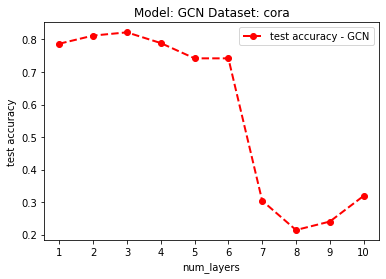

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
from google.colab import files

test_accs = []

for i in range(1, 11):
  args = {
          'model_type': 'GCN',
          'dataset': 'cora', #"cora/"citeseer"
          'num_layers': i,
          'batch_size': 32,
          'hidden_dim': 32,
          'dropout': 0.6,
          'epochs': 1000, 
          'opt': 'adam',
          'weight_decay': 1e-2,
          'lr': 0.01
        }
  args = objectview(args)

  dataset = Planetoid('/tmp/'+args.dataset, args.dataset)
  val_accs, losses, test_acc = train_ESTest(dataset, args)
  
  test_accs += [test_acc]

print(test_accs)

plt.title(f"Model: {args.model_type} Dataset: {dataset.name}")
plt.plot(range(1, 11), test_accs, "ro--", label=f"test accuracy - {args.model_type}", linewidth=2)
plt.xticks(range(1, 11))
plt.xlabel("num_layers")
plt.ylabel("test accuracy")
plt.legend()
plt.savefig(f"{args.model_type}_numlayers.png", dpi=500)
plt.show()
files.download(f"{args.model_type}_numlayers.png") 

# `SAGE - cora - num_layers -> 1 ... 10`

[0.74, 0.807, 0.824, 0.788, 0.763, 0.746, 0.319, 0.319, 0.319, 0.319]


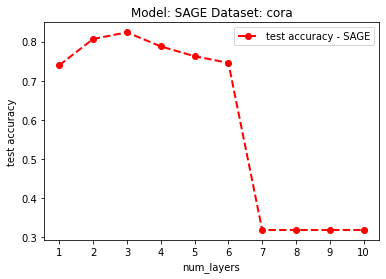

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
from google.colab import files

test_accs = []

for i in range(1, 11):
  args = {
          'model_type': 'SAGE',
          'dataset': 'cora', #"cora/"citeseer"
          'num_layers': i,
          'batch_size': 32,
          'hidden_dim': 40,
          'dropout': 0.6,
          'epochs': 1000, 
          'opt': 'adam',
          'weight_decay': 2e-2,
          'lr': 0.009
        }
  args = objectview(args)

  dataset = Planetoid('/tmp/'+args.dataset, args.dataset)
  val_accs, losses, test_acc = train_ESTest(dataset, args)
  
  test_accs += [test_acc]

print(test_accs)

plt.title(f"Model: {args.model_type} Dataset: {dataset.name}")
plt.plot(range(1, 11), test_accs, "ro--", label=f"test accuracy - {args.model_type}", linewidth=2)
plt.xticks(range(1, 11))
plt.xlabel("num_layers")
plt.ylabel("test accuracy")
plt.legend()
plt.savefig(f"{args.model_type}_numlayers.png", dpi=500)
plt.show()
files.download(f"{args.model_type}_numlayers.png") 

# ```GCN - cora - hidden_dim 8:x2:256```

GNNFactory(
  (conv_layers): ModuleList(
    (0): GCNConv(1433, 8)
    (1): GCNConv(8, 8)
    (2): GCNConv(8, 7)
  )
)
GNNFactory(
  (conv_layers): ModuleList(
    (0): GCNConv(1433, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 7)
  )
)
GNNFactory(
  (conv_layers): ModuleList(
    (0): GCNConv(1433, 32)
    (1): GCNConv(32, 32)
    (2): GCNConv(32, 7)
  )
)
GNNFactory(
  (conv_layers): ModuleList(
    (0): GCNConv(1433, 64)
    (1): GCNConv(64, 64)
    (2): GCNConv(64, 7)
  )
)
GNNFactory(
  (conv_layers): ModuleList(
    (0): GCNConv(1433, 128)
    (1): GCNConv(128, 128)
    (2): GCNConv(128, 7)
  )
)
GNNFactory(
  (conv_layers): ModuleList(
    (0): GCNConv(1433, 256)
    (1): GCNConv(256, 256)
    (2): GCNConv(256, 7)
  )
)
[0.808, 0.817, 0.822, 0.819, 0.827, 0.841]


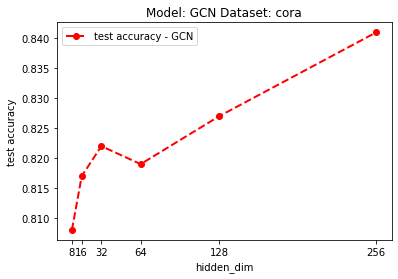

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
from google.colab import files

test_accs = []

for i in range(6):
  args = {
          'model_type': 'GCN',
          'dataset': 'cora', #"cora/"citeseer"
          'num_layers': 3,
          'batch_size': 32,
          'hidden_dim': 8*(1<<i),
          'dropout': 0.6,
          'epochs': 1000, 
          'opt': 'adam',
          'weight_decay': 1e-2,
          'lr': 0.01
        }
  args = objectview(args)

  dataset = Planetoid('/tmp/'+args.dataset, args.dataset)
  val_accs, losses, test_acc = train_ESTest(dataset, args)
  
  test_accs += [test_acc]

print(test_accs)

plt.title(f"Model: {args.model_type} Dataset: {dataset.name}")
plt.plot([8*(1<<i) for i in range(6)], test_accs, "ro--", label=f"test accuracy - {args.model_type}", linewidth=2)
plt.xlabel("hidden_dim")
plt.ylabel("test accuracy")
plt.xticks([8*(1<<i) for i in range(6)])
plt.legend()
plt.savefig(f"{args.model_type}_hiddendim.png", dpi=500)
plt.show()
files.download(f"{args.model_type}_hiddendim.png") 

# ```SAGE - cora - hidden_dim 8:x2:256```

GNNFactory(
  (conv_layers): ModuleList(
    (0): SAGEConv(1433, 8)
    (1): SAGEConv(8, 8)
    (2): SAGEConv(8, 7)
  )
)
GNNFactory(
  (conv_layers): ModuleList(
    (0): SAGEConv(1433, 16)
    (1): SAGEConv(16, 16)
    (2): SAGEConv(16, 7)
  )
)
GNNFactory(
  (conv_layers): ModuleList(
    (0): SAGEConv(1433, 32)
    (1): SAGEConv(32, 32)
    (2): SAGEConv(32, 7)
  )
)
GNNFactory(
  (conv_layers): ModuleList(
    (0): SAGEConv(1433, 64)
    (1): SAGEConv(64, 64)
    (2): SAGEConv(64, 7)
  )
)
GNNFactory(
  (conv_layers): ModuleList(
    (0): SAGEConv(1433, 128)
    (1): SAGEConv(128, 128)
    (2): SAGEConv(128, 7)
  )
)
GNNFactory(
  (conv_layers): ModuleList(
    (0): SAGEConv(1433, 256)
    (1): SAGEConv(256, 256)
    (2): SAGEConv(256, 7)
  )
)
[0.777, 0.762, 0.803, 0.811, 0.802, 0.812]


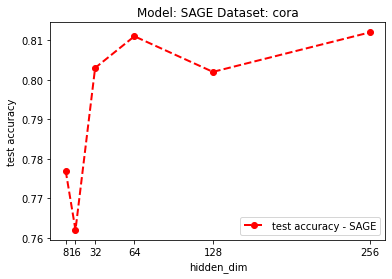

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
from google.colab import files

test_accs = []

for i in range(6):
  args = {
          'model_type': 'SAGE',
          'dataset': 'cora', #"cora/"citeseer"
          'num_layers': 3,
          'batch_size': 32,
          'hidden_dim': 8*(1<<i),
          'dropout': 0.6,
          'epochs': 1000, 
          'opt': 'adam',
          'weight_decay': 2e-2,
          'lr': 0.009
        }
  args = objectview(args)

  dataset = Planetoid('/tmp/'+args.dataset, args.dataset)
  val_accs, losses, test_acc = train_ESTest(dataset, args)
  
  test_accs += [test_acc]

print(test_accs)

plt.title(f"Model: {args.model_type} Dataset: {dataset.name}")
plt.plot([8*(1<<i) for i in range(6)], test_accs, "ro--", label=f"test accuracy - {args.model_type}", linewidth=2)
plt.xlabel("hidden_dim")
plt.ylabel("test accuracy")
plt.xticks([8*(1<<i) for i in range(6)])
plt.legend()
plt.savefig(f"{args.model_type}_hiddendim.png", dpi=500)
plt.show()
files.download(f"{args.model_type}_hiddendim.png") 